For reference use examples provided by Kwakkel (2018): https://github.com/quaquel/pyNetLogo/blob/55431ddb3c75c5dec41855fca874fbc7e9034ce1/examples/SALib_sequential.ipynb
Make sure when implementing the code, that the file directories where the model is stored is correct.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyNetLogo

#Import the sampling and analysis modules for a Sobol variance-based sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol

In [2]:
problem = { 
  'num_vars': 3,
  'names': ['MW-block-com',
            'MW-block-price-com', 
            'avg-cs-size'], 
  'bounds': [[80, 160],
             [500, 1500],
             [50 , 200]
            ]
}


In [16]:
import os

netlogo = pyNetLogo.NetLogoLink(gui=False)
model_file = os.path.join(netlogo.netlogo_home, 'models/Model 01-02.1 final.nlogo')
netlogo.load_model(model_file)

In [17]:
n = 100
param_values = saltelli.sample(problem, n, calc_second_order=True)

/var/folders/ql/w63wxz_17xnd0ryv6kshxn380000gn/T/ipykernel_9209/2042170087.py:2: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, n, calc_second_order=True)
/Users/rvdpn/opt/anaconda3/envs/netlogo-env/lib/python3.10/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)


In [18]:
param_values.shape

(800, 3)

In [19]:
results = pd.DataFrame(columns=['Avg csp finance'])
results

,Avg csp finance


In [20]:
import time

t0 = time.time()

for run in range(param_values.shape[0]):
    
    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(param_values[run,i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, param_values[run,i]))
            
    netlogo.command('setup')
    #Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(['count developers'], 520, include_t0=False)
    
    #For each run, save the mean value of the agent counts over time]
    results.loc[run, 'Avg csp finance'] = counts['count developers'].values.mean()
    
elapsed = time.time()-t0 #Elapsed runtime in seconds

In [21]:
results

,Avg csp finance
0,20.369231
1,20.413462
2,20.576923
3,15.809615
4,20.271154
...,...
795,20.538462
796,20.476923
797,14.796154
798,10.290385


In [22]:
results.to_csv('Sobol_sequential_csp_finances.csv')

In [23]:
results = pd.read_csv('Sobol_sequential_csp_finances.csv', header=0, index_col=0)

In [24]:
elapsed

25378.884925365448

In [25]:
Si = sobol.analyze(problem, results['Avg csp finance'].values, calc_second_order=True, print_to_console=False)

In [26]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

In [27]:
Si_df

,ST,ST_conf,S1,S1_conf
MW-block-com,0.963961,0.290491,-0.138989,0.233719
MW-block-price-com,1.008003,0.289521,-0.064972,0.246818
avg-cs-size,1.036959,0.303793,0.110862,0.262706


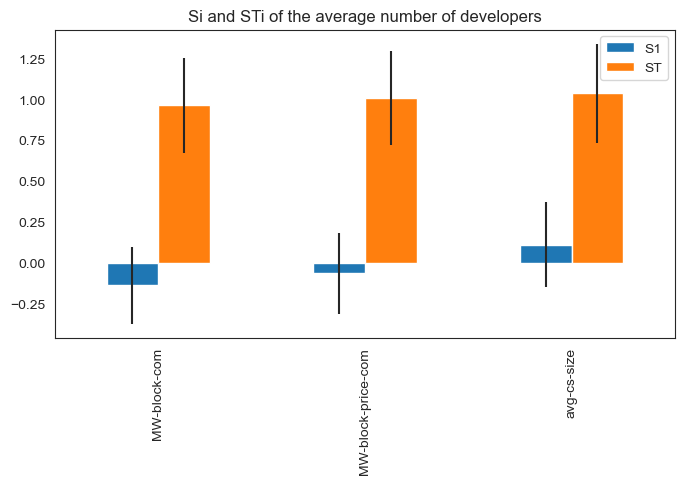

In [31]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
ax.set_title('Si and STi of the average number of developers')
fig.set_size_inches(8,4)

plt.savefig('Si and STi of the average number of developers', bbox_inches='tight')


plt.show()